# Calculating sea ice area and extent

> Updated August 2023 <br/>

<a href="https://polarwatch.noaa.gov/" target="_blank">NOAA PolarWatch</a> distributes gridded and tabular oceanographic data for polar regions. Many of the PolarWatch data products include sea ice related satellite data. Sea ice extent and sea ice area describe the area of ice coverage at a given time and play an important role as an environemntal indicator in climate research. 


**In this exercise, we will learn** how to calculate the sea ice area and extent using sea ice concentration and grid cell area data.  Please visit the  <a href="https://nsidc.org/learn/ask-scientist/what-difference-between-sea-ice-area-and-extent#:~:text=But%20NSIDC%20scientists%2C%20like%20most,the%20total%20in%20their%20entirety.&text=Calculating%20sea%20ice%20extent%20means,with%2015%20percent%20or%20more.">NSIDC website</a> for more detailed descriptions of the calculations. 

**The exercise demonstrates the following techniques:**
-   Downloading and saving a netcdf file from PolarWatch ERDDAP data server
-   Accessing satellite data and metadata in polar stereographic projection
-   Downloading and adding grid cell area data to the satellite data
-   Computing sea ice area and extent using sea ice concentration data
-   Plotting 12 month sea ice area and extent

**Datasets used:**

- The <a href="https://polarwatch.noaa.gov/catalog/ice-sq-nh-nsidc-cdr-v4/preview/?dataset=monthly&var=cdr_seaice_conc_monthly&time_min=2022-12-01T00:00:00Z&time_max=2022-12-01T00:00:00Z&proj=epsg3413&colorBar=KT_ice,,,0,1,">sea ice concentration (SIC) data</a> used in this exercise are proportion coverage values from the northern hemisphere at 25km resolution in the Polar stereographic projection North (EPSG: 3413).


-  Polar Stereographic Ancillary Grid Information that includes grid cell area values of  25k resolution Polar stereographic projection North.

**References:**
- <a href="https://polarwatch.noaa.gov/catalog/">PolarWatch Data Catalog</a>
- <a href="https://nsidc.org/learn/ask-scientist/what-difference-between-sea-ice-area-and-extent#:~:text=But%20NSIDC%20scientists%2C%20like%20most,the%20total%20in%20their%20entirety.&text=Calculating%20sea%20ice%20extent%20means,with%2015%20percent%20or%20more.">What's the difference between Sea ice area and extent?</a>
- <a href="https://nsidc.org/arcticseaicenews/">NSIDC Arctic Sea Ice News & Analysis</a>
- <a href="https://www.climate.gov/news-features/understanding-climate/understanding-climate-antarctic-sea-ice-extent">Climate.gov Understanding Climate: sea ice extent</a>




### Import Python modules

In [20]:
import urllib.request
import xarray as xr    
import numpy as np
import pyproj  
from pyproj import CRS
from pyproj import Transformer as transformer
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

## Arctic Sea Ice Concentration Data

The sea ice concentration (SIC) data are percent (proportion) coverage of ice within each grid cell. The SIC dataset used in this exercise is produced by the NOAA/NSIDC from passive microwave sensors using the Climate Data Record (CDR). The data are projected in the northern polar stereographic projection (EPSG:3413). This sea ice concentration data values in the dataset are represented as proportions ranging from 0 to 1. The resolution is 25km, meaning each grid in this data set represents a value that covers a 25km by 25km area.


**Data**

*Sea Ice Concentration*, NOAA/NSIDC Climate Data Record V4, Northern Hemisphere, 25km, Science Quality, 1978-2022, Monthly



**Useful links**

-   <a href="https://nsidc.org/data/g02202/versions/4" target="_blank">NSIDC Data Product Description</a>
-   <a href="https://nsidc.org/sites/default/files/g02202-v004-userguide_1_1.pdf" target="_blank">NSIDC Data Product User Guide (pdf)</a>
-   <a href="https://polarwatch.noaa.gov/catalog/ice-sq-nh-nsidc-cdr-v4/preview/?dataset=daily&var=cdr_seaice_conc&time_min=2022-05-31T00:00:00Z&time_max=2022-05-31T00:00:00Z&proj=epsg3413&colorBar=KT_ice|||0|1|" target="_blank">NOAA PolarWatch Data Product Page (download, preview)</a>

### Sending data request to PolarWatch ERDDAP server

ERDDAP URL can be constructed to customize the dataset to be received. 

```
https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday.nc?cdr_seaice_conc_monthly[(2021-01-01T00:00:00Z):1:(2021-12-01T00:00:00Z)][(4843696.04):1:(-4858210.64)][(-3850000.0):1:(3750000.0)]"
```

| Name   | Value| Description |
| ---:        |    :----   |          :--- |
| **ERDDAP URL**    |    https://polarwatch.noaa.gov/erddap/griddap  | ERDDAP URL for gridded datasets
| **Dataset ID** | nsidcG02202v4nhmday   | Unique ID for dataset from PolarWatch ERDDAP
| **File format**  | .nc        | netCDF and there are many other available file formats|
| **Variable name**   | cdr_seaice_conc_monthly        | list of variables from the dataset 
| **Time coverage**   | [(2021-01-01T00:00:00Z):1:(2021--01-01T00:00:00Z)]      |  Temporal date range (2021-01-01)
| **Spatial coverage**   | [(4843696.04):1:(-4858210.64)][(-3850000.0):1:(3750000.0)]  |  spatial range 

 



In [13]:
# Get data from ERDDAP URL
url="https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday.nc?cdr_seaice_conc_monthly[(2022-12-01T00:00:00Z):1:(2022-12-01T00:00:00Z)][(4843696.04):1:(-4858210.64)][(-3850000.0):1:(3750000.0)]"
urllib.request.urlretrieve(url, "sic.nc")

('sic.nc', <http.client.HTTPMessage at 0x142b3f190>)

In [4]:
# Create a dataset variable from nc file
ds = xr.open_dataset("sic.nc")


## Polar Stereographic Ancillary Grid Information

While the resolution of this data set is 25km (25km by 25km grid), the actual area of the grid depends on the grid projection. The NSIDC publishes netCDF files of actual grid areas of polar stereographic projections at different resolutions.  The file for this exercise is downloaded and saved in the <a href="#">resources folder</a> or can be downloaded from the NSIDC website at https://nsidc.org/data/nsidc-0771/versions/1.  


In [5]:
# Create a dataset variable from nc file
grid_area = xr.open_dataset("../resources/NSIDC0771_CellArea_PS_N25km_v1.0.nc")

In [16]:
grid_area

<xarray.Dataset>
Dimensions:    (x: 304, y: 448)
Coordinates:
  * x          (x) float64 -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * y          (y) float64 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
Data variables:
    crs        int32 ...
    cell_area  (y, x) float64 ...
Attributes: (12/38)
    title:                     Polar Stereo Ancillary Grid Information
    summary:                   This data set provides the total on-Earth surf...
    id:                        10.5067/N6INPBT8Y104
    metadata_link:             https://doi.org/10.5067/N6INPBT8Y104
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced and supported by the N...
    ...                        ...
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    product_version:           1.0

In [6]:
# Get grid values from SIC data
xgrid = ds['xgrid'].values
ygrid = ds['ygrid'].values

# Get min and max of SIC
xmax, xmin, ymax, ymin = np.max(xgrid), np.min(xgrid), np.max(ygrid), np.min(ygrid)

# Subset grid area to match SIC data grids
sub_area = grid_area.sel(x=slice(xmin, xmax), y=slice(ymax, ymin))

### Adding the grid areas  to the data set

In [7]:
# Add grid area to the dataset
cell_area = sub_area.cell_area.values
ds['area'] = (('ygrid', 'xgrid'), cell_area)

### Calculating Sea ice area and extent

In [17]:
# Subset the dataset to exclude flag values
seaice_ds = ds.where(ds.cdr_seaice_conc_monthly <= 1)

# Compute sea ice area
icearea = seaice_ds.area * seaice_ds.cdr_seaice_conc_monthly[0][:] 

# Convert the unit from m^2 to km^2
tot_icearea = np.sum(icearea) /1000000  
print("Sea Ice Area (km^2): ", tot_icearea.item())

# Compute sea ice extent
ext = seaice_ds.area * xr.where(seaice_ds.cdr_seaice_conc_monthly[0][:] < 0.15, 0, 1)
extent = np.sum(ext)/1000000 
print("Sea Ice Extent (km^2):", extent.item())

Sea Ice Area (km^2):  11105290.184104066
Sea Ice Extent (km^2): 12391285.84189521


## Working with 12 month time series

The next exercise is to download 12 time step (12 months) sea ice concentration data and compute sea ice area and extent for each month.

The modified url :

<code>url="https:\/\/polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday.nc?cdr_seaice_conc_monthly[(**2021-01-01T00:00:00Z**):1:( **2021-12-01T00:00:00Z** )][(4843696.04):1:(-4858210.64)][(-3850000.0):1:(3750000.0)]</code>

In [21]:
# Get 12 months data
url="https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday.nc?cdr_seaice_conc_monthly[(2021-01-01T00:00:00Z):1:(2021-12-01T00:00:00Z)][(4843696.04):1:(-4858210.64)][(-3850000.0):1:(3750000.0)]"
urllib.request.urlretrieve(url, "sic12.nc")

# Open and assign data from the file to a variable ds using xarray
ds = xr.open_dataset("sic12.nc")

# Add grid area to the dataset
cell_area = sub_area.cell_area.values
ds['area'] = (('ygrid', 'xgrid'), cell_area)

# Subset the dataset to exclude flag values
seaice_ds = ds.where(ds.cdr_seaice_conc_monthly <= 1)

# Calculate sea ice area by month
icearea = seaice_ds.area * seaice_ds.cdr_seaice_conc_monthly
icea_month = icearea.sum(dim=['xgrid', 'ygrid']) / 1000000

# Calculate sea ice extent by month
ext = seaice_ds.area * xr.where(seaice_ds.cdr_seaice_conc_monthly < 0.15, 0, 1)
extent = ext.sum(dim=['xgrid', 'ygrid']) / 1000000

### Plotting monthly sea ice area and extent

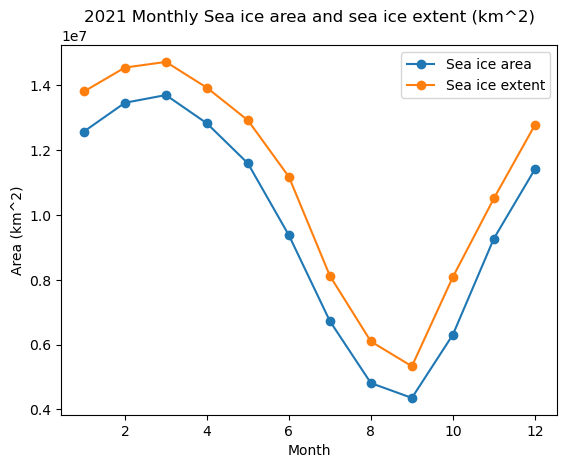

In [22]:

fig, ax = plt.subplots()

# Plot the data as a line
ax.plot(list(range(1, 13)), icea_month, label='Sea ice area', marker='o', linestyle='-')
ax.plot(list(range(1, 13)), extent, label='Sea ice extent', marker='o', linestyle='-')

# Add a title and labels
ax.set_title('2021 Monthly Sea ice area and sea ice extent (km^2)')
ax.set_xlabel('Month')
ax.set_ylabel('Area (km^2)')

# Display the legend
ax.legend()

# Show the plot
plt.show()